In [69]:
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg
import os, shutil
import geopandas as gp
import choroplethNYC as cp
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [70]:
# code snippets for first sections on data set and cleansing courtesy of Socratis, TA of Civic Analytics

In [71]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [72]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [73]:
# Read data
df_xls = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

# Convert to .csv
df_xls.to_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv', encoding='utf-8')
df = pd.read_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [74]:
df.head()

,Unnamed: 0,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole Buil

In [75]:
del df['Unnamed: 0']

# This transformation is in case your system doesn't recognize the current encoding
cols = df.columns.str.replace('\xc2\xb2', '_2')
df.columns = cols

In [76]:
df.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

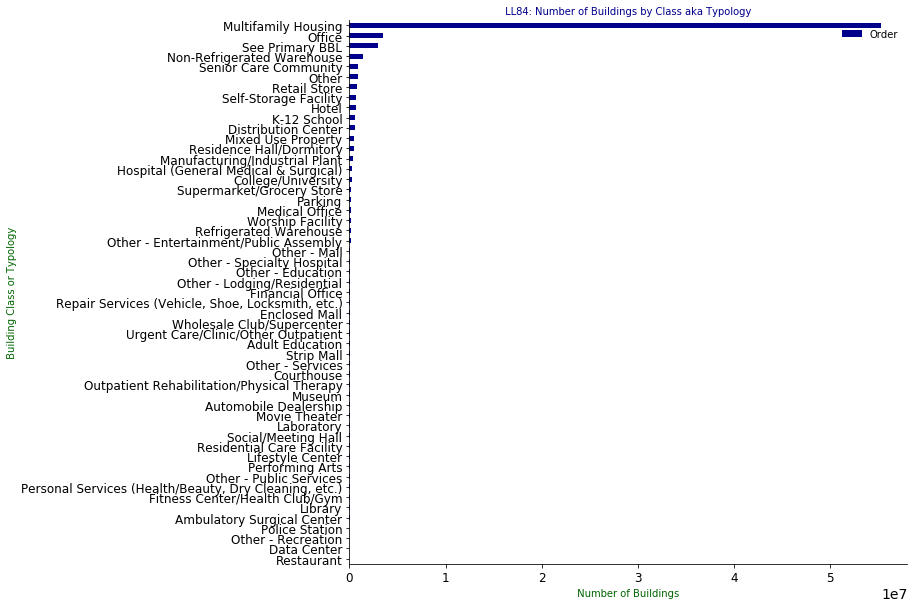

In [77]:
df.groupby('Primary Property Type - Self Selected')['Order'].sum()\
            .sort_values()\
            .plot(kind = 'barh', figsize=(10,10), fontsize=12, color ='darkblue')
        
# plot.title("Number of Buildings by Class (Typology)")

plt.title(' LL84: Number of Buildings by Class aka Typology ', fontsize=10, color='darkblue')
plt.ylabel(' Building Class or Typology ', fontsize=10, color = 'darkgreen')
plt.xlabel(' Number of Buildings ', fontsize=10, color = 'darkgreen')

plt.legend(fontsize=10, loc=1)

In [78]:
mydict = dict(zip(df.groupby('Primary Property Type - Self Selected')['Order'].count().index, 
         df.groupby('Primary Property Type - Self Selected')['Order'].count().values))

# show top 5 most frequent building typology
sorted(mydict.items(), key=operator.itemgetter(1), reverse=True)[:6]

[('Multifamily Housing', 8699),
 ('Office', 1233),
 ('See Primary BBL', 447),
 ('Hotel', 236),
 ('Non-Refrigerated Warehouse', 177),
 ('Other', 129)]

In [79]:
df = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing'] # most common typology

In [80]:
df.describe()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft_2),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),DEP Provided Water Use (kgal)
count,8.699000e+03,8699.000000,8.698000e+03,6978.000000,8487.000000,8.699000e+03,8699.000000,8699.000000,7513.000000,8654.000000,7440.000000,8406.000000,7458.000000,8654.000000,7440.000000,7.914000e+03,7.458000e+03,8.643000e+03,8.406000e+03,8.669000e+03,8.669000e+03,8.679000e+03,8.487000e+03,8.699000e+03,5.499000e+03,4956.000000,4560.000000
mean,3.476663e+06,6351.661800,2.225283e+09,1108.404271,10610.728879,1.467861e+05,1.490746,99.616623,56.629842,405.938456,448.661250,13.919153,2.238898,548.974451,592.683306,2.991518e+07,3.078148e+05,4.536019e+06,1.280868e+06,4.093800e+03,1.628570e+03,2.462726e+03,1.405344e+05,1.499596e+05,1.193724e+04,94.932849,6801.782149
std,8.229126e+05,3267.420728,1.181873e+09,1694.046711,568.795592,2.299528e+05,4.153277,3.358280,30.477155,9520.852245,10224.456799,228.398920,95.844071,10564.343498,11268.237888,1.347821e+09,1.387439e+07,5.199372e+07,1.493466e+07,8.535570e+04,6.841710e+04,5.095997e+04,2.599077e+05,2.329603e+05,8.786550e+04,860.237215,7047.573041
min,1.443214e+06,1.000000,1.000088e+09,1.000000,10001.000000,5.800000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.002800e+04,5.800000e+01,0.000000e+00,0.000000,1.000000
25%,2.742914e+06,3765.000000,NaN,NaN,NaN,6.510000e+04,1.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.620950e+04,NaN,NaN,NaN
50%,3.114529e+06,6373.000000,NaN,NaN,NaN,8.821400e+04,1.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.958000e+04,NaN,NaN,NaN
75%,4.384553e+06,9181.500000,NaN,NaN,NaN,1.452840e+05,1.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.480205e+05,NaN,NaN,NaN
max,5.053345e+06,11971.000000,5.054918e+09,76179.000000,11694.000000,6.940450e+06,161.000000,100.000000,100.000000,801504.700000,798135.700000,10510.900000,7981.000000,841652.400000,838112.300000,1.101676e+11,1.101676e+09,3.729784e+09,1.093137e+09,5.860677e+06,5.852949e+06,2.193799e+06,8.512479e+06,6.940450e+06,3.638813e+06,52143.200000,129781.600000


In [81]:
df.head()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole Building,10

In [82]:
df['Site EUI (kBtu/ft_2)'].isnull().values.any()

True

In [83]:
# Check if there are missing values
print ("Are there missing values? -->", df['Site EUI (kBtu/ft_2)'].isnull().values.any())
print ("There are %i missing values out of %i properties (%.1f percent)" %(df['Site EUI (kBtu/ft_2)'].isnull().sum(), 
                                                                        len(df), 
                                                                        df['Site EUI (kBtu/ft_2)'].isnull().sum()
                                                                          /float(len(df))*100))

('Are there missing values? -->', True)
There are 45 missing values out of 8699 properties (0.5 percent)


In [84]:
# Drop nans
df = df.dropna(subset=['Site EUI (kBtu/ft_2)'])
print ('Examples after dropping NaNs:', len(df))

('Examples after dropping NaNs:', 8654)


In [85]:
# Drop zero EUI values
df = df[df['Site EUI (kBtu/ft_2)']>0]
print ('Examples after dropping zeros:', len(df))

('Examples after dropping zeros:', 8652)


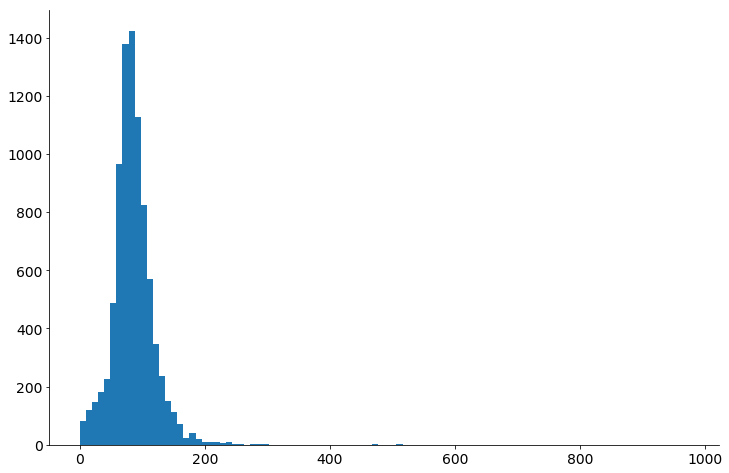

In [86]:
#plt.hist(df['Site EUI (kBtu/ft_2)'], bins=200)
plt.hist(df['Site EUI (kBtu/ft_2)'][df['Site EUI (kBtu/ft_2)']<1000], bins=100)
plt.show()

In [87]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

df['eui'] = df['Site EUI (kBtu/ft_2)']
df['log_eui'] = np.log10(df.eui)
df = clean(df)
print ('Examples after cleaning EUI:', len(df))

('Examples after cleaning EUI:', 8369)


In [88]:
df.eui.describe()

count    8369.000000
mean       87.188804
std        29.988660
min        21.000000
25%        69.200000
50%        83.400000
75%       101.300000
max       304.800000
Name: eui, dtype: float64

In [89]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

df['eui'] = df['Site EUI (kBtu/ft_2)']
df['log_eui'] = np.log10(df.eui)
df = clean(df)
print ('Examples after cleaning EUI:', len(df))

('Examples after cleaning EUI:', 7881)


In [90]:
df.eui.describe()

count    7881.000000
mean       87.536341
std        23.711886
min        41.000000
25%        70.800000
50%        84.300000
75%       101.000000
max       165.200000
Name: eui, dtype: float64

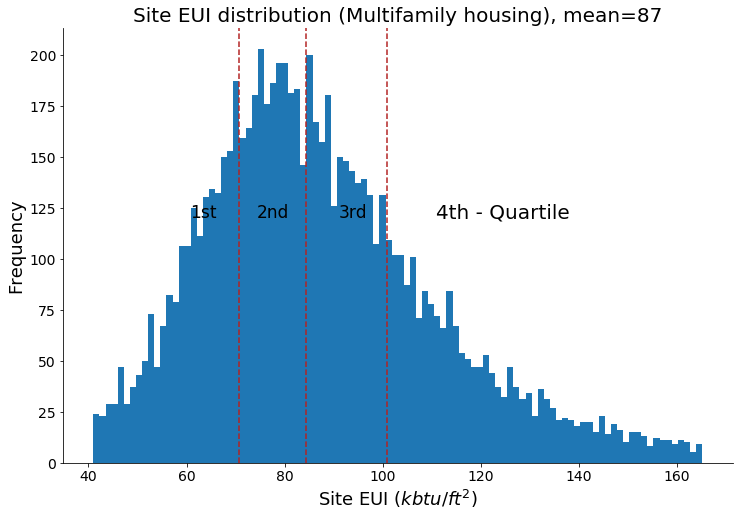

In [91]:
plt.hist(df['Site EUI (kBtu/ft_2)'], bins=100)
for label, pos in zip(['1st', '2nd', '3rd'], df['Site EUI (kBtu/ft_2)'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-10, 120, label, fontsize=17)
plt.text(pos+10, 120, '4th - Quartile', fontsize=20)
plt.title('Site EUI distribution (Multifamily housing), mean=87',fontsize = 20)
plt.xlabel('Site EUI ($kbtu/ft^{2}$)')
plt.ylabel('Frequency')
plt.show()

In [92]:
def makeCorrPlots(x, y):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = df[[x,y]]
    tmp = tmp.dropna()
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(tmp[x].astype(float), tmp[y])
    
    # plot2
    plt.scatter(tmp[x].astype(float), tmp[y], color=tableau20[0], alpha=0.5)
    plt.plot(tmp[x].astype(float),intercept + slope*tmp[x].astype('float'), color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(tmp[x].astype('float'), tmp[y])[0][1]))

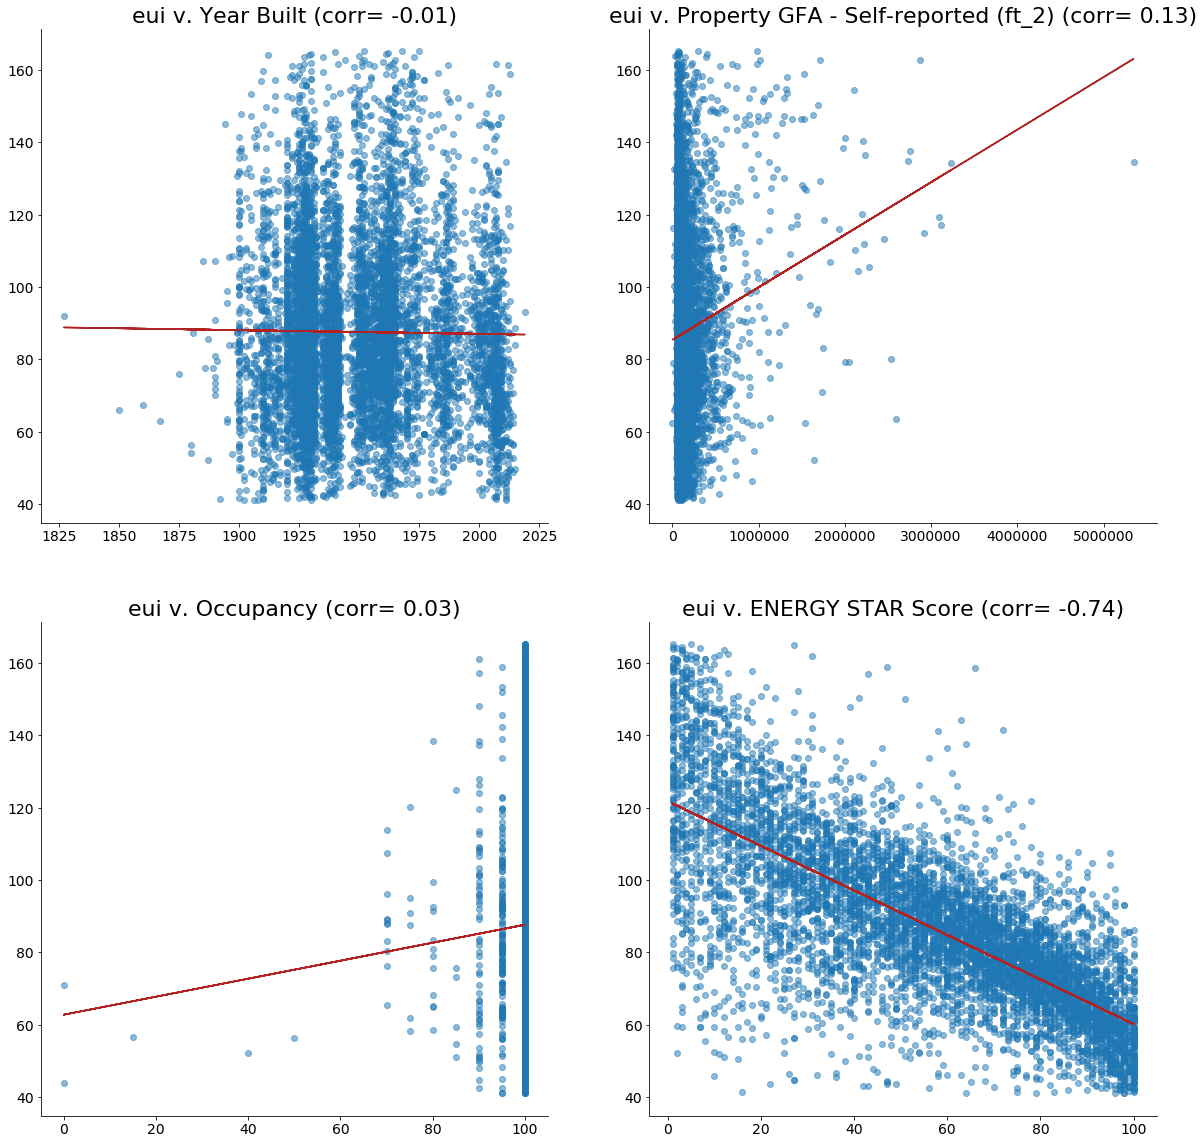

In [93]:
plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft_2)', 'Occupancy', 'ENERGY STAR Score'],1):
    plt.subplot(2,2,i)
    makeCorrPlots(var, 'eui')

In [94]:
df.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

In [95]:
# urllib.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile", "PUMA.zip")

In [96]:
# !unzip PUMA.zip # unzip data

In [97]:
pumashp = gpd.GeoDataFrame.from_file("geo_export_c7ee2e8a-a3ce-4155-8a78-ade3b449130d.shp")

In [98]:
pumashp["puma"] = pumashp["puma"].astype(int)
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [99]:
pumashp.crs

{'init': u'epsg:4326'}

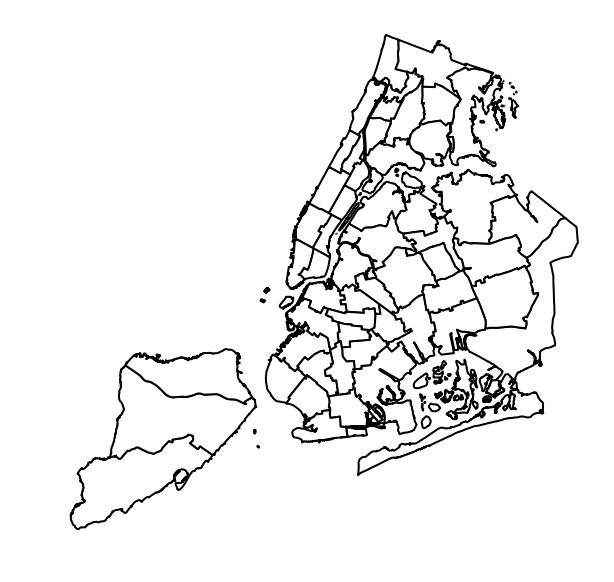

In [100]:
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

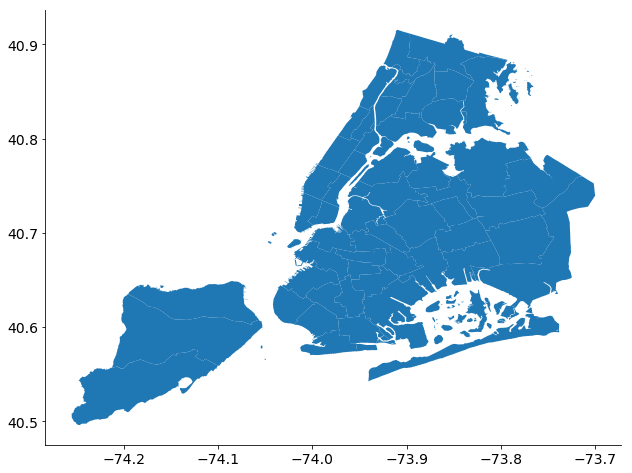

In [101]:
pumashp.plot()

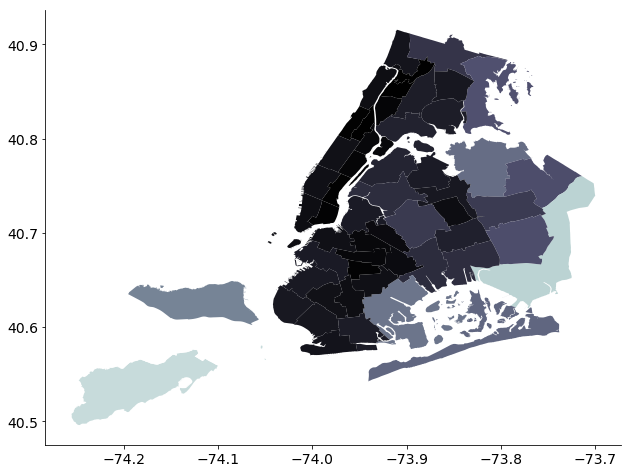

In [102]:
pumashp.plot(column="shape_area", cmap="bone");

In [103]:

# filename = "pluto.zip"

#urllib.request.urlretrieve(url, filename)

# os.system("mv " + filename + " " + os.getenv("PUIDATA")) #moves file to PUIDATA directory

In [104]:
# os.system("unzip " + os.getenv("PUIDATA") + "/" + filename + " -d " + os.getenv("PUIDATA") + "/plutoBblData")

In [105]:
files = os.listdir(os.getenv("PUIDATA") + "/plutoBblData")
shpfile = [x for x in files if 'shp' in x]


In [106]:
shpfile[0]

'pluto.shp'

In [107]:

plutoshp = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/plutoBblData" + "/" + shpfile[0])

In [108]:
plutoshp.head()

,bbl,geometry
0,4.013370e+09,POLYGON ((-73.90176465590628 40.74355716784439...
1,4.013310e+09,POLYGON ((-73.90498103525515 40.74456399140851...
2,4.035750e+09,POLYGON ((-73.90083199485892 40.69930147431369...
3,4.034810e+09,POLYGON ((-73.90367775761688 40.70416338368288...
4,4.035140e+09,POLYGON ((-73.89916429316976 40.70305656384154...


In [109]:
plutoshp.crs

{'init': u'epsg:4326'}

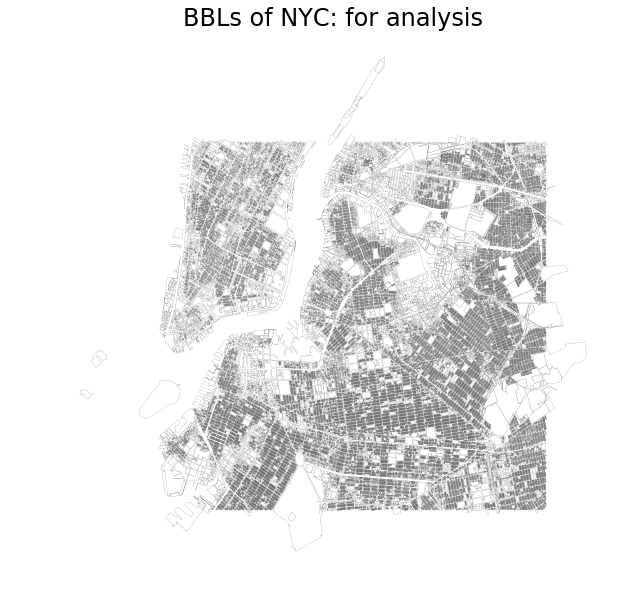

In [110]:
# see map of PLUTO shape files
cp.choroplethNYC(plutoshp, column=None, color="white", edgecolor="black", lw=.1);
pl.title("BBLs of NYC: for analysis", fontsize = 24);

In [111]:
df.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

In [112]:
df = df.rename(columns={'NYC Borough, Block and Lot (BBL)': 'bbl'}) # rename to bbl to make same as PLUTO data set to merge later
df.head()

,Record Number,Order,bbl,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN,51.3,1.710117
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual,44.9,1.652246
3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Bui

In [113]:
# df['bbl'] = df['bbl'].astype(int)
df.head()

,Record Number,Order,bbl,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN,51.3,1.710117
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual,44.9,1.652246
3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Bui

In [114]:
plutoshp.head()

,bbl,geometry
0,4.013370e+09,POLYGON ((-73.90176465590628 40.74355716784439...
1,4.013310e+09,POLYGON ((-73.90498103525515 40.74456399140851...
2,4.035750e+09,POLYGON ((-73.90083199485892 40.69930147431369...
3,4.034810e+09,POLYGON ((-73.90367775761688 40.70416338368288...
4,4.035140e+09,POLYGON ((-73.89916429316976 40.70305656384154...


In [115]:
plutoshp['bbl'] = plutoshp['bbl'].astype(int)

In [116]:
euipluto = pd.merge(df, plutoshp, on='bbl')
euipluto.head()

,Record Number,Order,bbl,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui,geometry
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467,POLYGON ((-73.98294345124495 40.71587986192018...
1,2792771.0,9,1.000088e+09,NaN,NaN,1087700,"Whitehall Properties, LLC",Not Applicable: Standalone Property,Not Applicable: Standalone Property,39.0,WHITEHALL STREET,10004.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Other",Multifamily Housing,132653.0,Other,36402,Not Available,Not Available,1985,1.0,100.0,Whole Building,Whole Building,1.0,137.2,139.2,12.8,0.1,234.2,233.8,Not Available,13512269.8,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2137974.0,21379.7,7547536.0,2155535.8,1742.2,1116.3,625.9,169061.0,169055.0,NaN,NaN,2016-03-23 12:34:18,NaN,NaN,NaN,137.2,2.137354,"POLYGON ((-74.0124513162785 40.702828403493, -..."
2,2782299.0,16,1.000110e+09,NaN,NaN,1085816,Beaver Tower,Not Applicable: Standalone Property,Not Applicable: Standalone Property,26.0,BEAVER STREET,10004.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Office",Multifamily Housing,52091.0,Office,2000,Not Available,Not Available,1909,1.0,100.0,Whole Building,Whole Building,NaN,76.3,76.0,5.1,0.6,117.5,116.3,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,3161081.8,31610.8,967208.2,277619.6,248.1,167.9,80.2,51387.0,54091.0,17.6,0.32,2016-04-22 14:47:40,17.6,Eligible,ABS,76.3,1.882525,"POLYGON ((-74.01188886499595 40.7048883794419,..."
3,4408640.0,21,1.000150e+09,NaN,NaN,1000047,Le Rivage,Not Applicable: Standalone Property,Not Applicable: Standalone Property,21.0,WEST STREET,10006.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Supermarket/Grocery Store",Mu

In [117]:
euipluto.head()

,Record Number,Order,bbl,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui,geometry
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467,POLYGON ((-73.98294345124495 40.71587986192018...
1,2792771.0,9,1.000088e+09,NaN,NaN,1087700,"Whitehall Properties, LLC",Not Applicable: Standalone Property,Not Applicable: Standalone Property,39.0,WHITEHALL STREET,10004.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Other",Multifamily Housing,132653.0,Other,36402,Not Available,Not Available,1985,1.0,100.0,Whole Building,Whole Building,1.0,137.2,139.2,12.8,0.1,234.2,233.8,Not Available,13512269.8,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2137974.0,21379.7,7547536.0,2155535.8,1742.2,1116.3,625.9,169061.0,169055.0,NaN,NaN,2016-03-23 12:34:18,NaN,NaN,NaN,137.2,2.137354,"POLYGON ((-74.0124513162785 40.702828403493, -..."
2,2782299.0,16,1.000110e+09,NaN,NaN,1085816,Beaver Tower,Not Applicable: Standalone Property,Not Applicable: Standalone Property,26.0,BEAVER STREET,10004.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Office",Multifamily Housing,52091.0,Office,2000,Not Available,Not Available,1909,1.0,100.0,Whole Building,Whole Building,NaN,76.3,76.0,5.1,0.6,117.5,116.3,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,3161081.8,31610.8,967208.2,277619.6,248.1,167.9,80.2,51387.0,54091.0,17.6,0.32,2016-04-22 14:47:40,17.6,Eligible,ABS,76.3,1.882525,"POLYGON ((-74.01188886499595 40.7048883794419,..."
3,4408640.0,21,1.000150e+09,NaN,NaN,1000047,Le Rivage,Not Applicable: Standalone Property,Not Applicable: Standalone Property,21.0,WEST STREET,10006.0,Manhattan,In Compliance,Multifamily Housing,"Multifamily Housing, Supermarket/Grocery Store",Mu

In [118]:
# !wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nybb_17d.zip # boro contours

In [119]:
# !unzip nybb_17d.zip

In [120]:
boroughs2 = gpd.GeoDataFrame.from_file("nybb_17d/nybb.shp")

In [121]:
from fiona.crs import from_epsg
boroughs = boroughs2.to_crs(epsg=4326)


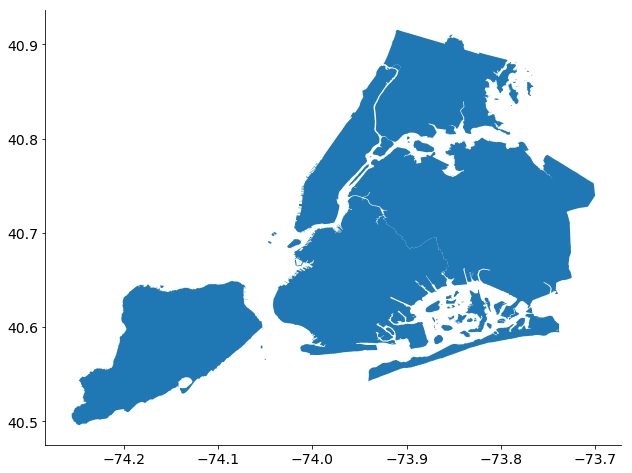

In [122]:
boroughs.plot()

In [123]:
geoeuipluto = gpd.GeoDataFrame(euipluto, crs={'init': 'epsg:4326'})

(40.6, 40.8)

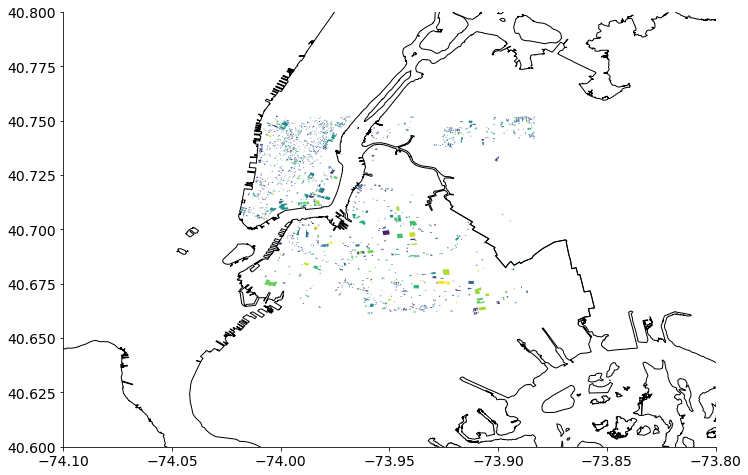

In [124]:
ax = boroughs.plot(color='None', edgecolor='k')
geoeuipluto.plot(column='eui', ax=ax,)
ax.set_xlim(-74.1,-73.8)
ax.set_ylim(40.6, 40.8)

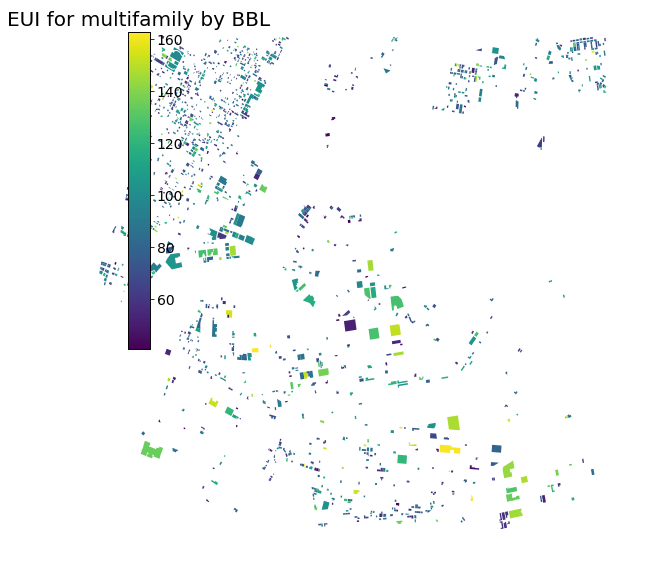

In [125]:
cp.choroplethNYC(geoeuipluto, column='eui');
pl.title("EUI for multifamily by BBL", fontsize = 20);

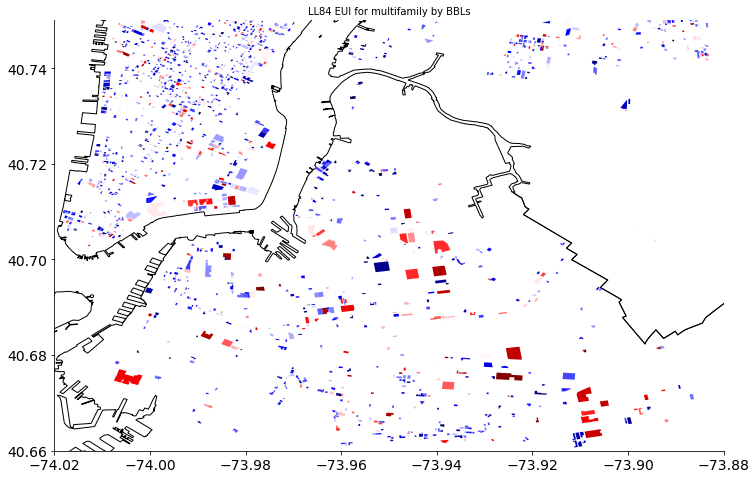

In [126]:
ax = boroughs.plot(color='None', edgecolor='k')
geoeuipluto.plot(column='eui', ax=ax, cmap="seismic")
ax.set_xlim(-74.02,-73.88)
ax.set_ylim(40.66, 40.75)
pl.title("LL84 EUI for multifamily by BBLs", fontsize = 10);

In [127]:
type(geoeuipluto["Zip Code"][0])

numpy.float64

In [128]:
problem_zips = geoeuipluto[geoeuipluto["Zip Code"].isin([11203.0, 11207.0, 11212.0, 11213.0, 11216.0, 11225.0, 11233.0, 11236.0, 11205.0, 11206.0, 11207.0, 11211.0, 11213.0, 11216.0, 11221.0, 11222.0, 11233.0, 11237.0, 11207.0, 11208.0, 11239.0, 11256.0, 11414.0, 11415.0, 11416.0, 11417.0, 11418.0, 11419.0, 11420.0, 11421.0, 11430.0, 11693.0 ])]

In [129]:
problem_zips.describe()

,Record Number,Order,bbl,Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft_2),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),DEP Provided Water Use (kgal),eui,log_eui
count,2.760000e+02,276.000000,2.760000e+02,276.000000,276.000000,2.760000e+02,276.000000,276.000000,252.000000,276.000000,250.000000,274.000000,255.000000,276.000000,250.000000,2.660000e+02,2.550000e+02,2.760000e+02,2.740000e+02,276.000000,276.000000,276.000000,2.760000e+02,2.760000e+02,188.000000,163.000000,139.000000,276.000000,276.000000
mean,3.633997e+06,7976.550725,3.020548e+09,544.586957,11215.018116,1.233977e+05,1.318841,99.420290,55.186508,83.268841,81.951200,5.786496,0.594902,129.075000,128.372000,8.022142e+06,8.210987e+04,2.658278e+06,7.669798e+05,670.405435,449.945290,220.463043,1.166208e+05,1.246170e+05,9223.664894,96.951595,7583.635252,83.268841,1.902219
std,7.743232e+05,233.058887,9.093421e+06,472.380582,8.661075,1.686840e+05,2.251417,3.671634,30.274194,24.658399,23.550568,3.566480,0.249593,37.880659,37.491651,1.538023e+07,1.578512e+05,4.239914e+06,1.224925e+06,1111.265524,804.219139,351.632846,1.433836e+05,1.688741e+05,29786.148030,379.035352,10185.694049,24.658399,0.125972
min,2.540632e+06,7688.000000,3.011850e+09,1.000000,11203.000000,3.737000e+04,0.000000,50.000000,1.000000,41.100000,40.400000,0.100000,0.000000,51.300000,51.300000,1.369700e+03,1.370000e+01,2.249720e+04,6.670800e+03,136.100000,0.000000,1.900000,5.011200e+04,5.040000e+04,0.000000,0.000000,433.500000,41.100000,1.613842
25%,2.829013e+06,7770.750000,3.013238e+09,167.000000,11207.000000,6.253725e+04,1.000000,100.000000,NaN,64.375000,NaN,NaN,NaN,105.650000,NaN,NaN,NaN,9.499038e+05,NaN,304.750000,197.175000,78.775000,6.091925e+04,6.278500e+04,NaN,NaN,NaN,64.375000,1.808717
50%,3.528032e+06,7894.500000,3.017094e+09,400.500000,11213.000000,7.946050e+04,1.000000,100.000000,NaN,79.950000,NaN,NaN,NaN,121.650000,NaN,NaN,NaN,1.422438e+06,NaN,386.700000,272.300000,118.000000,7.865550e+04,8.046800e+04,NaN,NaN,NaN,79.950000,1.902818
75%,4.398445e+06,8189.250000,3.027313e+09,837.000000,11222.750000,1.173720e+05,1.000000,100.000000,NaN,95.225000,NaN,NaN,NaN,149.300000,NaN,NaN,NaN,2.417570e+06,NaN,593.175000,406.725000,200.475000,1.172790e+05,1.222375e+05,NaN,NaN,NaN,95.225000,1.978750
max,5.050010e+06,8466.000000,3.046330e+09,2060.000000,11237.000000,1.552000e+06,29.000000,100.000000,100.000000,159.800000,162.700000,23.400000,1.500000,250.500000,250.500000,1.606799e+08,1.617131e+06,3.602952e+07,1.038878e+07,11529.500000,8541.500000,2988.100000,1.435162e+06,1.552000e+06,391261.500000,4820.330000,75327.500000,159.800000,2.203577


In [130]:
problem_zips.columns

Index([u'Record Number', u'Order', u'bbl', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Normalized Site EUI (kBtu/ft_2)'

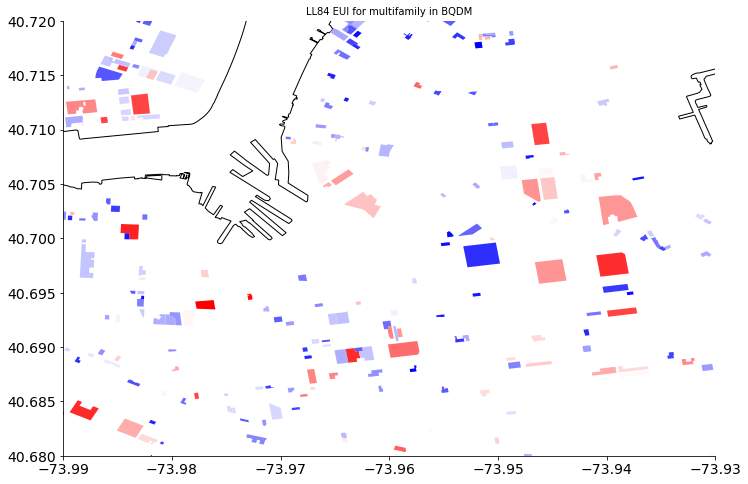

In [131]:
ax = boroughs.plot(color='none', edgecolor='k')
geoeuipluto.plot(column='eui', ax=ax, cmap="bwr")

ax.set_xlim(-73.99,-73.93)
ax.set_ylim(40.68, 40.72)
pl.title("LL84 EUI for multifamily in BQDM", fontsize = 10);

In [132]:
boroughs.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330434.340939,1.623914e+09,(POLYGON ((-74.05050806403248 40.5664220341941...
1,1,Manhattan,361657.416718,6.366004e+08,(POLYGON ((-74.01092841268033 40.6844914725762...
2,3,Brooklyn,741150.814455,1.937596e+09,(POLYGON ((-73.86706149472113 40.5820879768267...
3,4,Queens,895729.259626,3.044780e+09,(POLYGON ((-73.83668274106698 40.5949466970491...
4,2,Bronx,463454.790585,1.186619e+09,(POLYGON ((-73.89680883223768 40.7958084451931...


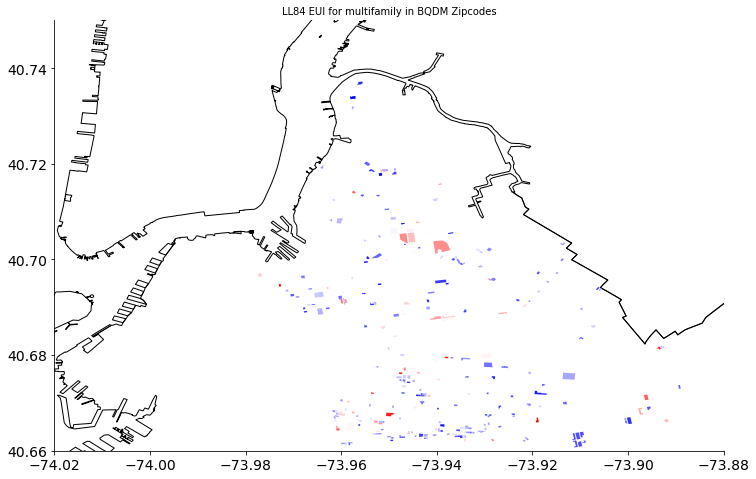

In [133]:
# fig, ax, cb = cp.choroplethNYC(pumashplc, column='linkNYCp100p', cmap='bone', cb=True, edgecolor='grey');

ax = boroughs.plot(color='none', edgecolor='k')
problem_zips.plot(column='eui', ax=ax, cmap="bwr", markersize=8)

ax.set_xlim(-74.02,-73.88)
ax.set_ylim(40.66, 40.75)

pl.title("LL84 EUI for multifamily in BQDM Zipcodes", fontsize = 10);

In [134]:
problem_zips.groupby("Zip Code")['eui'].mean()

Zip Code
11203.0     75.212500
11205.0     83.714286
11206.0     81.486207
11207.0     93.560000
11211.0     80.071429
11212.0     77.940000
11213.0     78.055556
11216.0    102.005882
11221.0     89.187500
11222.0     62.600000
11225.0     89.433333
11233.0     67.933333
11237.0     69.433333
Name: eui, dtype: float64

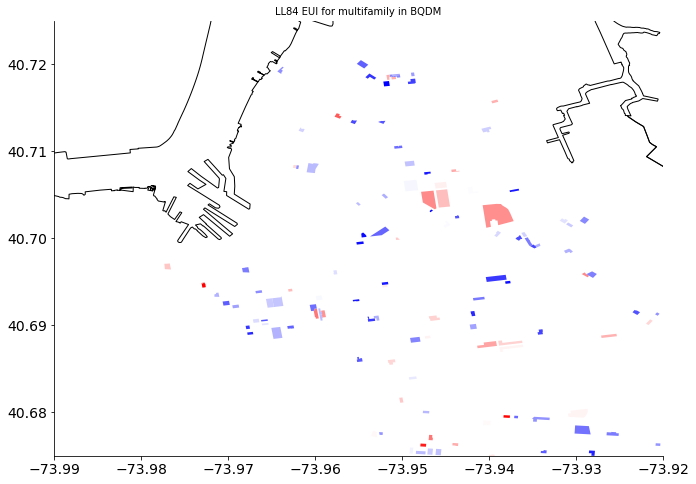

In [135]:
ax = boroughs.plot(color='none', edgecolor='k')
problem_zips.plot(column='eui', ax=ax, cmap="bwr")
# figure how to map zipcodes

ax.set_xlim(-73.99,-73.92)
ax.set_ylim(40.675, 40.725)
pl.title("LL84 EUI for multifamily in BQDM", fontsize = 10);